### Задание
1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов----) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)



### Импорт библиотек и изучение данных

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode

In [2]:
customers=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-holodkov-20/project1/olist_customers_dataset.csv',decimal='-')

In [3]:
items=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-holodkov-20/project1/olist_order_items_dataset.csv',decimal='-')

In [4]:
orders=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-holodkov-20/project1/olist_orders_dataset.csv',decimal='-')

In [5]:
customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [6]:
items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93


In [7]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [8]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [9]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [10]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [11]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [12]:
items.dtypes

order_id               object
order_item_id           int64
product_id             object
seller_id              object
shipping_limit_date    object
price                  object
freight_value          object
dtype: object

In [13]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [14]:
#переведем price в float
items.price=pd.to_numeric(items.price,errors='coerce')

In [65]:
# Перевод столбцов с временем в datetime
orders.order_purchase_timestamp = pd.to_datetime(orders['order_purchase_timestamp'])
orders.order_approved_at = pd.to_datetime(orders['order_approved_at'])

### Что считается покупкой?
Покупкой будем считать тот заказ, который оплачен и имеет статус не (canceled).Так как имеется факт оплаты, и при этом товар либо доставлен, либо доставляется. А статус заказа не доступен "unavailable" может означать только временную недоступность товара.

In [66]:
orders_approved=orders[orders.order_approved_at.notnull()]

In [67]:
# Создание df с подтверждёнными покупками
purchases=orders_approved.query('order_status !="canceled"')
purchases

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_2
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-13 21:18:39
...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,2017-03-09 09:54:05
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,2018-02-06 12:58:58
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,2017-08-27 14:46:43
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2018-01-08 21:28:27


### 1.Сколько у нас пользователей, которые совершили покупку только один раз?

In [68]:
customers[['customer_id', 'customer_unique_id']].merge(purchases, on='customer_id') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'n_of_purchases'}) \
    .query('n_of_purchases == 1') \
    .shape[0]

92621

ОТВЕТ 92621

### 2.Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? )

In [69]:
# Создание столбца с датой в виде "год-месяц"
orders.order_approved_at = pd.to_datetime(orders.order_approved_at)
orders['order_approved_at_year_and_month'] = orders['order_approved_at'].dt.strftime('%Y-%m') 

In [70]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_2,order_approved_at_year_and_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-02 10:56:33,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-24 20:41:37,2018-07


In [71]:
not_delivered_by_year_and_month=orders.query('order_status!="delivered"')\
                                      .groupby(['order_id','order_approved_at_year_and_month','order_status'],as_index=False)\
                                      .agg({'order_id': 'count'})

In [72]:
not_delivered_by_year_and_month.head(2)

,order_approved_at_year_and_month,order_status,order_id
0,2017-10,unavailable,1
1,2018-03,shipped,1


In [73]:
not_delivered_by_year_and_month_mean = not_delivered_by_year_and_month\
    .groupby('order_approved_at_year_and_month', as_index=False)\
    .agg({'order_id': 'count'}).mean().round()

In [74]:
not_delivered_by_year_and_month_mean

order_id    128.0
dtype: float64

In [75]:
not_delivered_by_year_and_month_gr=not_delivered_by_year_and_month.groupby(['order_approved_at_year_and_month','order_status'], as_index=False)\
                                                                  .agg({'order_id':'count'})

In [76]:
not_delivered_by_year_and_month_gr

,order_approved_at_year_and_month,order_status,order_id
0,2016-10,canceled,20
1,2016-10,invoiced,18
2,2016-10,processing,2
3,2016-10,shipped,9
4,2016-10,unavailable,6
...,...,...,...
101,2018-08,canceled,32
102,2018-08,invoiced,24
103,2018-08,shipped,47
104,2018-08,unavailable,13


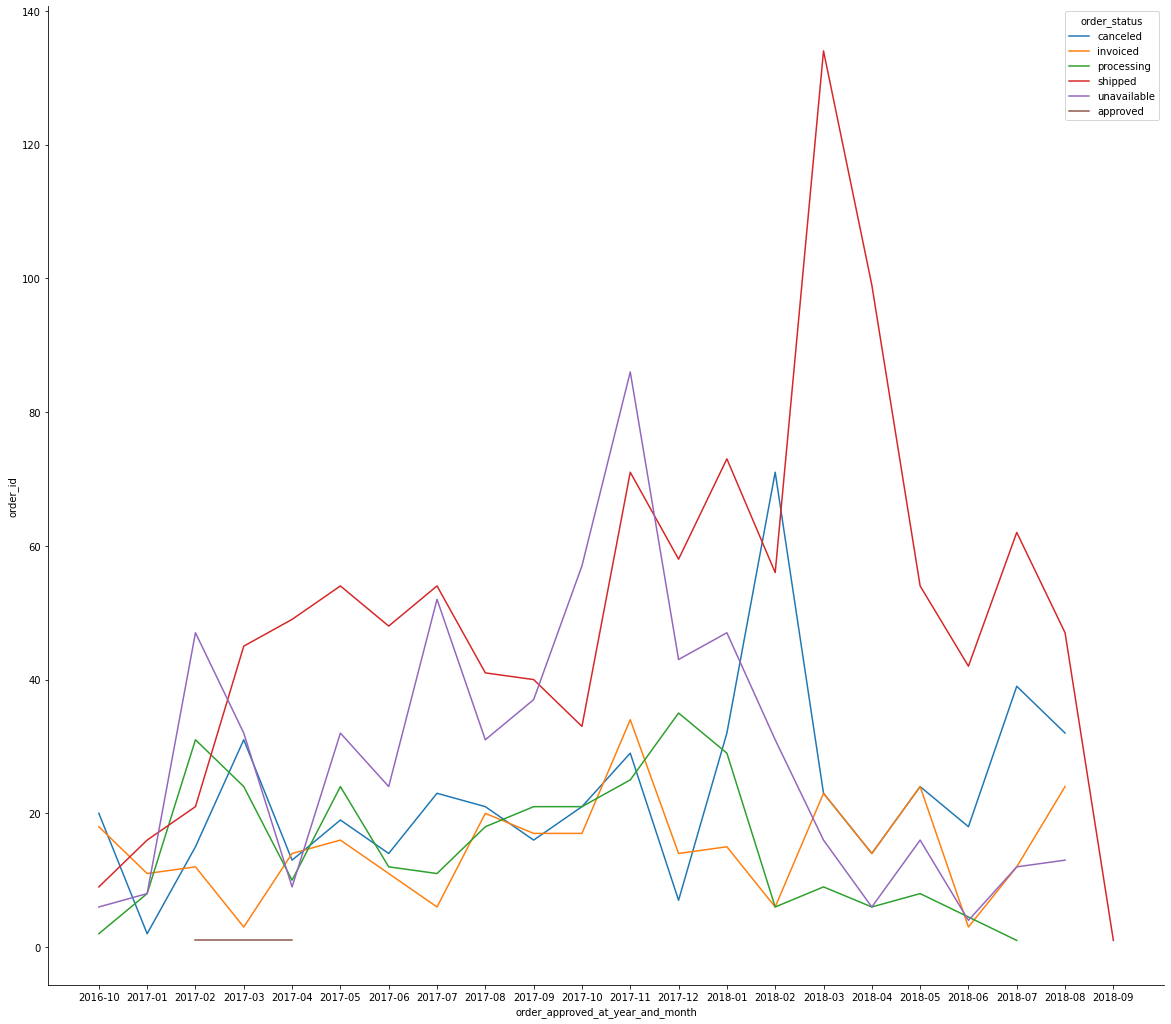

In [77]:
plt.figure(figsize=(20, 18))
sns.lineplot(x='order_approved_at_year_and_month', y='order_id',
             data=not_delivered_by_year_and_month_gr, hue='order_status')
sns.despine()

Ответ 128

### 3.По каждому товару определить, в какой день недели товар чаще всего покупается?

Считаем, что дата покупки = order_purchase_timestamp

In [78]:
# Создание столбца с датой в виде "дня недели"
orders['order_purchase_timestamp_2'] = pd.to_datetime(orders.order_purchase_timestamp)
orders['order_approved_at_year_and_month'] = orders['order_approved_at'].dt.strftime('%a') 

In [79]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_2,order_approved_at_year_and_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-02 10:56:33,Mon
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-24 20:41:37,Thu


In [80]:
# Merge df'ов для получения product_id
order_item = orders[['order_approved_at_year_and_month','order_id']].merge(items[['order_id', 'product_id']], on='order_id')

In [81]:
order_item_day=order_item.groupby(['order_approved_at_year_and_month','product_id'], as_index=False)\
          .agg({'order_id':'count'})\
          .rename(columns={'order_id': 'number_of_goods'})\
          .sort_values('number_of_goods', ascending=False)

In [82]:
order_item_day

,order_approved_at_year_and_month,product_id,number_of_goods
48146,Tue,aca2eb7d00ea1a7b8ebd4e68314663af,119
44407,Tue,53b36df67ebb7c41585e8d54d6772e08,105
6110,Fri,aca2eb7d00ea1a7b8ebd4e68314663af,96
58029,Wed,aca2eb7d00ea1a7b8ebd4e68314663af,89
43636,Tue,422879e10f46682990de24d770e7f83d,89
...,...,...,...
23881,Sat,d487d19bd9ea9420465fc556ce17ef4e,1
23883,Sat,d48c8d7a322bda722704d0ba7506e9a1,1
23884,Sat,d493f5a208254fe85b3ab55d898461a1,1
23886,Sat,d4a3b5aa064bf44e74f1e71862bea22a,1


### 4.Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [83]:
# Создание df для анализа
purchases_all = purchases[['customer_id','order_purchase_timestamp','order_id']].merge(customers[['customer_id', 'customer_unique_id']], on='customer_id')

In [84]:
purchases_all.dtypes

customer_id                         object
order_purchase_timestamp    datetime64[ns]
order_id                            object
customer_unique_id                  object
dtype: object

In [85]:
# Перевод столбa с временем в datetime
purchases_all.order_purchase_timestamp=pd.to_datetime(purchases_all.order_purchase_timestamp)

In [86]:
# Создания столбца с днями месяца
purchases_all['days_in_month']=purchases_all.order_purchase_timestamp.dt.daysinmonth

In [87]:
# Создания столбца с годом и месяцем
purchases_all['order_purchase_time_month_years'] = purchases_all['order_purchase_timestamp'].dt.strftime('%Y-%b')

In [88]:
# Создаём столбец с количсетвом недель в месяце
purchases_all['order_purchase_time_week'] = pd.to_numeric(round((purchases_all.days_in_month/7),2))

In [89]:
purchases_all.head(2)

,customer_id,order_purchase_timestamp,order_id,customer_unique_id,days_in_month,order_purchase_time_month_years,order_purchase_time_week
0,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,31,2017-Oct,4.43
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,31,2018-Jul,4.43


In [90]:
# Находим количество покупок в месяц
orders_by_customer_month=purchases_all.groupby(['customer_unique_id','order_purchase_time_month_years','order_purchase_time_week'], as_index=False).agg({'order_id':'count'})

In [91]:
orders_by_customer_month.sort_values('order_id',ascending=False)

,customer_unique_id,order_purchase_time_month_years,order_purchase_time_week,order_id
7273,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-Jan,4.43,6
76309,c8460e4251689ba205045f3ea17884a1,2018-Aug,4.43,4
14391,25a560b9a6006157838aab1bdbd68624,2017-Apr,4.29,4
23794,3e43e6105506432c953e165fb2acf44c,2018-Feb,4.00,4
50309,83e7958a94bd7f74a9414d8782f87628,2017-Jan,4.43,4
...,...,...,...,...
32662,5596da0d33997ed7cd9020fa7af0649b,2017-Jul,4.43,1
32661,559620bb304bfa901a54939d04dd203f,2018-Jan,4.43,1
32660,5595fb3aa8c496ff254d154b263e80cd,2018-Mar,4.43,1
32659,5595cc8e21946d81a82054dea257108a,2018-Jul,4.43,1


In [92]:
# Находим среднее в неделю 
orders_by_customer_month['avg_orders_week']= orders_by_customer_month['order_id']/orders_by_customer_month['order_purchase_time_week']

In [93]:
# Итоговая отсортированная таблица 
orders_by_customer_month.sort_values('avg_orders_week',ascending=False)

,customer_unique_id,order_purchase_time_month_years,order_purchase_time_week,order_id,avg_orders_week
7273,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-Jan,4.43,6,1.354402
61811,a239b8e2fbce33780f1f1912e2ee5275,2017-Feb,4.00,4,1.000000
68962,b4e4f24de1e8725b74e4a1f4975116ed,2018-Feb,4.00,4,1.000000
23794,3e43e6105506432c953e165fb2acf44c,2018-Feb,4.00,4,1.000000
14391,25a560b9a6006157838aab1bdbd68624,2017-Apr,4.29,4,0.932401
...,...,...,...,...,...
40735,6abd878bb355f29f91678a8c7512da0d,2018-Jan,4.43,1,0.225734
40736,6abfc2aef3b5c263bcf70e56a6b79fc1,2017-Aug,4.43,1,0.225734
40737,6ac0e68ca06c7a126ba938508ed19f86,2018-Mar,4.43,1,0.225734
40738,6ac1c6087ba110c7b36bb63c2efa55e8,2018-Jul,4.43,1,0.225734


### 5.Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

In [94]:
# Cоздание дф для анализа
gruop_df =  ['customer_unique_id', 'customer_id', 'order_id', 'order_purchase_timestamp']
group_analysis = purchases[['customer_id', 'order_id', 'order_purchase_timestamp']]\
    .merge(customers[['customer_id', 'customer_unique_id']])

In [95]:
group_analysis.head(2)

,customer_id,order_id,order_purchase_timestamp,customer_unique_id
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231


In [96]:
# Создание когорт

df1 = group_analysis.groupby('customer_unique_id', as_index=False)\
    .agg({'order_purchase_timestamp': 'min'})\
    .rename(columns={'order_purchase_timestamp_y': 'group'})\
    .sort_values('order_purchase_timestamp')

group_analysis = group_analysis.merge(df1, on='customer_unique_id', how='outer')    

In [97]:
group_analysis['period'] = group_analysis['order_purchase_timestamp_x'].dt.to_period('M')
group_analysis['group'] = group_analysis['order_purchase_timestamp_y'].dt.to_period('M')

In [98]:
group_analysis.head(2)

,customer_id,order_id,order_purchase_timestamp_x,customer_unique_id,order_purchase_timestamp_y,period,group
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-09-04 11:26:38,2017-10,2017-09
1,31f31efcb333fcbad2b1371c8cf0fa84,69923a4e07ce446644394df37a710286,2017-09-04 11:26:38,7c396fd4830fd04220f754e42b4e5bff,2017-09-04 11:26:38,2017-09,2017-09


In [99]:
another_gruop_df = ['customer_id', 'order_id', 'order_purchase_timestamp_x', 'order_purchase_timestamp_y']
group_analysis.drop(another_gruop_df, axis=1, inplace=True)

In [100]:
al_dente_df = group_analysis.groupby(['group', 'period'], as_index=False)\
    .agg({'customer_unique_id': 'count'})

In [101]:
# Количество клиентов в нулевой день

zero_month_df = al_dente_df.query('period == group')[['group', 'customer_unique_id']]

In [102]:
d_rename = {'customer_unique_id_x': 'customer_unique_id_period', 'customer_unique_id_y': 'customer_unique_id_group'}

almost_ready_df = al_dente_df\
    .merge(zero_month_df, on='group', how='outer')\
    .rename(columns=d_rename)

In [103]:
# Вычисление RR

a = almost_ready_df.customer_unique_id_period / almost_ready_df.customer_unique_id_group
almost_ready_df['rr'] = round((a) * 100, 2)

In [104]:
cohort_rr_df = almost_ready_df.pivot_table(index='group', columns='period', values='rr')\
    .fillna(0)

In [105]:
cohort_rr_df

period,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
group,,,,,,,,,,,,,,,,,,,,,
2016-09,100.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-10,0.0,100.0,0.0,0.0,0.00,0.00,0.33,0.00,0.00,0.33,...,0.00,0.33,0.00,0.33,0.00,0.67,0.67,0.00,0.00,0.00
2016-12,0.0,0.0,100.0,100.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2017-01,0.0,0.0,0.0,100.0,0.38,0.25,0.13,0.38,0.13,0.50,...,0.13,0.76,0.38,0.13,0.13,0.25,0.38,0.00,0.13,0.00
2017-02,0.0,0.0,0.0,0.0,100.00,0.23,0.29,0.11,0.40,0.11,...,0.11,0.29,0.17,0.17,0.11,0.06,0.06,0.29,0.00,0.00
2017-03,0.0,0.0,0.0,0.0,0.00,100.00,0.53,0.34,0.45,0.34,...,0.08,0.38,0.15,0.23,0.11,0.15,0.23,0.08,0.15,0.00
2017-04,0.0,0.0,0.0,0.0,0.00,0.00,100.00,0.63,0.25,0.21,...,0.30,0.17,0.25,0.08,0.08,0.04,0.08,0.08,0.21,0.00
2017-05,0.0,0.0,0.0,0.0,0.00,0.00,0.00,100.00,0.49,0.58,...,0.16,0.25,0.33,0.25,0.33,0.27,0.03,0.22,0.27,0.00
2017-06,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,100.00,0.44,...,0.35,0.22,0.13,0.22,0.31,0.31,0.16,0.13,0.22,0.00


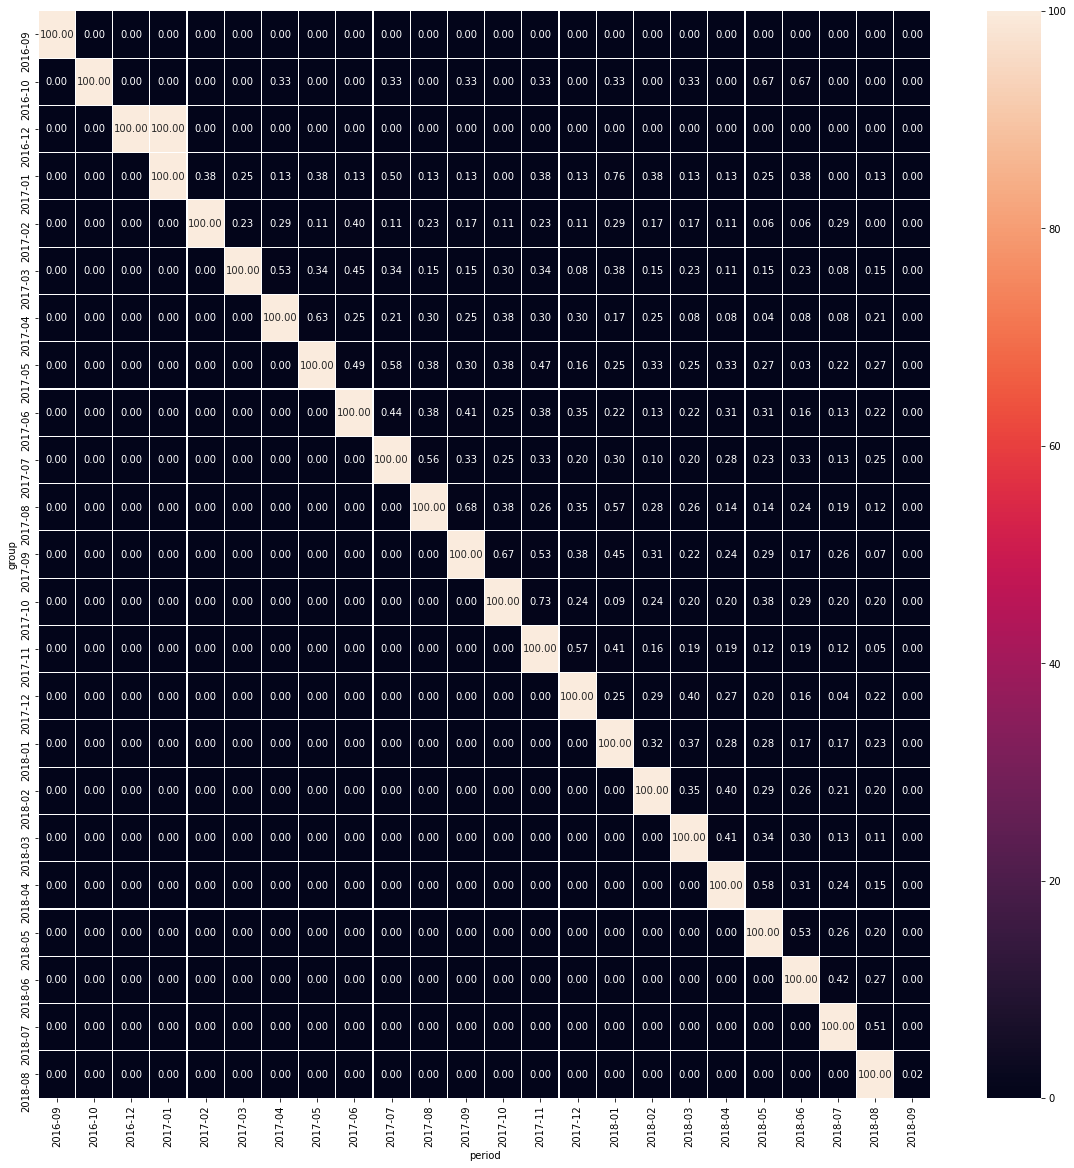

In [106]:
plt.figure(figsize=(20, 20))
sns.heatmap(cohort_rr_df, annot=True, fmt='.2f',linewidths=.1)

Ответ искомый месяц 2017-03

### 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики:

### R - время от последней покупки пользователя до текущей даты
### F - суммарное количество покупок у пользователя за всё время
### M - сумма покупок за всё время

### Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю

In [107]:
purchases.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_2
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-24 20:41:37


In [108]:
# для каждого клиента посчитаем дату последней покупки, сумму заказов и кол-во заказов за весь период
customer_data = purchases \
                            .merge(items, on='order_id') \
                            .merge(customers, on='customer_id') \
                            .groupby('customer_unique_id', as_index=False) \
                            .agg({'order_id': 'nunique',
                                'price': 'sum',
                                'order_approved_at': 'max'})

In [109]:
customer_data.head(2)

,customer_unique_id,order_id,price,order_approved_at
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.9,2018-05-10 11:11:18
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.9,2018-05-07 18:25:44


In [110]:
# считаем количество дней с последнего дня заказа
customer_data['recency'] = customer_data.order_approved_at.apply(lambda x: (datetime.datetime.now() - x).days)

In [111]:
# приведем табличку в нужный вид
customer_data = customer_data[['customer_unique_id', 'order_id', 'price', 'recency']] \
                    .rename(columns={'order_id': 'frequancy',
                                    'price'    : 'monetary'})

In [112]:
customer_data.head(2)

,customer_unique_id,frequancy,monetary,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.9,1447
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.9,1450


In [113]:
# определяем границы для каждого сегмента
customer_data[['recency', 'frequancy', 'monetary']].quantile([.2, .4, .6, .8])

,recency,frequancy,monetary
0.2,1428.0,1.0,39.9
0.4,1512.0,1.0,69.9
0.6,1603.0,1.0,109.9
0.8,1719.0,1.0,179.9


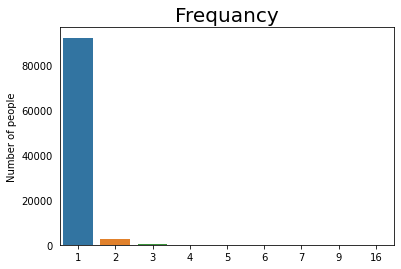

In [114]:
# посмотрим на распределение количества заказов (frequancy)
ax = sns.countplot(x=customer_data.frequancy)
# добавляем заголовки для оси y и для графика
ax.set_ylabel("Number of people", size = 10)
ax.set_title( "Frequancy", size = 20)
ax.set(xlabel=None)
# убираем вывод значений отметок осей
plt.tick_params(left = False)

In [115]:
customer_data.frequancy.value_counts()

1     92090
2      2650
3       188
4        29
5         9
6         5
7         3
16        1
9         1
Name: frequancy, dtype: int64

In [116]:
# поскольку по частоте квинтили получаются одинаковыми, так как основная масса покупателей покупала один раз
# возьмем границы по частоте вручную (основываясь на таблицу выше)

quintiles = customer_data[['recency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles['frequancy'] = {0.2: 1, .4: 2, .6: 3, .8: 4}

In [117]:
quintiles

{'recency': {0.2: 1428.0, 0.4: 1512.0, 0.6: 1603.0, 0.8: 1719.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9},
 'frequancy': {0.2: 1, 0.4: 2, 0.6: 3, 0.8: 4}}

In [118]:
# присвоим каждому рангу конкретное значение

def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

In [119]:
customer_data['R'] = customer_data['recency'].apply(lambda x: r_score(x))
customer_data['F'] = customer_data['frequancy'].apply(lambda x: fm_score(x, 'frequancy'))
customer_data['M'] = customer_data['monetary'].apply(lambda x: fm_score(x, 'monetary'))

In [120]:
customer_data['RFM'] = customer_data.R.map(str) + customer_data.F.map(str) + customer_data.M.map(str)

In [121]:
customer_data.head(2)

,customer_unique_id,frequancy,monetary,recency,R,F,M,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.9,1447,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.9,1450,4,1,1,411


In [122]:
'По итогам анализа мы получили {} RFM-сегментов'.format(customer_data['RFM'].nunique())

'По итогам анализа мы получили 80 RFM-сегментов'

In [123]:
# поскольку с таким количеством сегментов сложно работать, сведем полученные сегменты к 11 общепринятым
segt_map = {r'[1-2][1-2]': 'hibernating',
            r'[1-2][3-4]': 'at risk',
            r'[1-2]5': 'can\'t loose',
            r'3[1-2]': 'about to sleep',
            r'33': 'need attention',
            r'[3-4][4-5]': 'loyal customers',
            r'41': 'promising',
            r'51': 'new customers',
            r'[4-5][2-3]': 'potential loyalists',
            r'5[4-5]': 'champions'}
customer_data['Segment'] = customer_data['R'].map(str) + customer_data['F'].map(str)
customer_data['Segment'] = customer_data['Segment'].replace(segt_map, regex=True)

In [124]:
# посчитаем количество клиентов по каждому сегменту
customer_data.Segment.value_counts(normalize=True)

hibernating            0.398311
about to sleep         0.200072
new customers          0.194112
promising              0.193344
potential loyalists    0.012666
at risk                0.000748
need attention         0.000316
loyal customers        0.000211
champions              0.000211
can't loose            0.000011
Name: Segment, dtype: float64

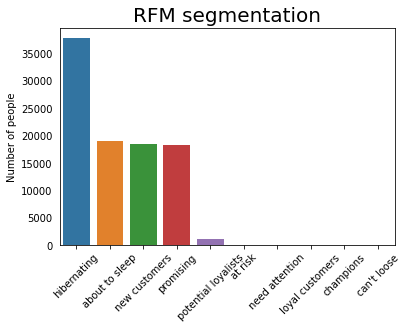

In [125]:
# посмотрим, как распределяются эти сегменты
ax = sns.countplot(x=customer_data.Segment,order = customer_data.Segment.value_counts().index)
# разворачиваем подписи 
plt.xticks(rotation=45)
# добавляем заголовки для оси y и для графика
ax.set_ylabel("Number of people", size = 10)
ax.set_title( "RFM segmentation", size = 20)
ax.set(xlabel=None)
# убираем вывод значений отметок осей
plt.tick_params(left = False)

In [126]:
# построим таблицу с границами каждого из сегментов
borders = pd.DataFrame(quintiles)

In [127]:
borders

,recency,monetary,frequancy
0.2,1428.0,39.9,1
0.4,1512.0,69.9,2
0.6,1603.0,109.9,3
0.8,1719.0,179.9,4


In [128]:
# добавим для каждого значения соотвествующий ему ранг для итогового расчета сегментации
borders['R'] = borders.recency.apply(lambda x: r_score(x))
borders['M'] = borders.monetary.apply(lambda x: fm_score(x, 'monetary'))
borders['F'] = borders.frequancy.apply(lambda x: fm_score(x, 'frequancy'))

In [129]:
# добавим значение следующего ранга
borders['recency_1'] = borders.recency.shift(1)
borders['monetary_1'] = borders.monetary.shift(1)
borders['frequancy_1'] = borders.frequancy.shift(1)

In [130]:
borders

,recency,monetary,frequancy,R,M,F,recency_1,monetary_1,frequancy_1
0.2,1428.0,39.9,1,5,1,1,NaN,NaN,NaN
0.4,1512.0,69.9,2,4,2,2,1428.0,39.9,1.0
0.6,1603.0,109.9,3,3,3,3,1512.0,69.9,2.0
0.8,1719.0,179.9,4,2,4,4,1603.0,109.9,3.0


In [131]:
# объединим нижнюю и верхнюю границы для каждого ранга
borders['R_borders'] = (borders.fillna(0).recency_1.astype('int').map(str)
                            + ' - ' + borders.fillna(0).recency.astype('int').map(str))
borders['F_borders'] = (borders.fillna(0).frequancy_1.astype('int').map(str)
                            + ' - ' + borders.fillna(0).frequancy.astype('int').map(str))
borders['M_borders'] = (borders.fillna(0).monetary_1.map(str)
                            + ' - ' + borders.fillna(0).monetary.map(str))

In [132]:
# уберем лишние столбцы из датафрейма
borders_new = borders[['R', 'F', 'M', 'R_borders', 'F_borders', 'M_borders']]

In [133]:
borders_new

,R,F,M,R_borders,F_borders,M_borders
0.2,5,1,1,0 - 1428,0 - 1,0.0 - 39.9
0.4,4,2,2,1428 - 1512,1 - 2,39.9 - 69.9
0.6,3,3,3,1512 - 1603,2 - 3,69.9 - 109.9
0.8,2,4,4,1603 - 1719,3 - 4,109.9 - 179.9


In [134]:
# создадим строчку с границами, которые не попали в датафрейм
new_line = pd.DataFrame([[1, 5, 5, 'more then ' + str(borders.recency.max().astype('int')),
'more then ' + str(borders.frequancy.max()),
'more then ' + str(borders.monetary.max())]], columns=borders_new.columns)

In [135]:
# добавим новую строчку
borders_new = borders_new.append(new_line)

In [136]:
borders_new

,R,F,M,R_borders,F_borders,M_borders
0.2,5,1,1,0 - 1428,0 - 1,0.0 - 39.9
0.4,4,2,2,1428 - 1512,1 - 2,39.9 - 69.9
0.6,3,3,3,1512 - 1603,2 - 3,69.9 - 109.9
0.8,2,4,4,1603 - 1719,3 - 4,109.9 - 179.9
0.0,1,5,5,more then 1719,more then 4,more then 179.9


In [137]:
# сгруппируем клиентов по каждому сегменту
customer_data_agg = customer_data \
                    .groupby(['R', 'F', 'M'], as_index=False) \
                    .agg({'customer_unique_id': 'count'}) \
                    .rename(columns={'customer_unique_id': 'customers'})

In [138]:
# добавляем границы метрик
customer_data_agg = customer_data_agg.merge(borders_new[['R', 'R_borders']], on='R') \
                                        .merge(borders_new[['F', 'F_borders']], on='F') \
                                        .merge(borders_new[['M', 'M_borders']], on='M')

In [139]:
customer_data_agg

,R,F,M,customers,R_borders,F_borders,M_borders
0,1,1,1,4131,more then 1719,0 - 1,0.0 - 39.9
1,2,1,1,3745,1603 - 1719,0 - 1,0.0 - 39.9
2,3,1,1,4005,1512 - 1603,0 - 1,0.0 - 39.9
3,4,1,1,3740,1428 - 1512,0 - 1,0.0 - 39.9
4,5,1,1,3951,0 - 1428,0 - 1,0.0 - 39.9
...,...,...,...,...,...,...,...
75,4,4,5,6,1428 - 1512,3 - 4,more then 179.9
76,5,4,5,13,0 - 1428,3 - 4,more then 179.9
77,3,5,5,4,1512 - 1603,more then 4,more then 179.9
78,4,5,5,7,1428 - 1512,more then 4,more then 179.9


In [140]:
customer_data_agg['borders'] = ('R: ' + customer_data_agg.R_borders +
                                    ', F: ' + customer_data_agg.F_borders +
                                    ', M: ' + customer_data_agg.M_borders)

In [141]:
customer_data_agg = customer_data_agg[['R', 'F', 'M', 'customers', 'borders']]

In [142]:
# итоговая таблица
customer_data_agg

,R,F,M,customers,borders
0,1,1,1,4131,"R: more then 1719, F: 0 - 1, M: 0.0 - 39.9"
1,2,1,1,3745,"R: 1603 - 1719, F: 0 - 1, M: 0.0 - 39.9"
2,3,1,1,4005,"R: 1512 - 1603, F: 0 - 1, M: 0.0 - 39.9"
3,4,1,1,3740,"R: 1428 - 1512, F: 0 - 1, M: 0.0 - 39.9"
4,5,1,1,3951,"R: 0 - 1428, F: 0 - 1, M: 0.0 - 39.9"
...,...,...,...,...,...
75,4,4,5,6,"R: 1428 - 1512, F: 3 - 4, M: more then 179.9"
76,5,4,5,13,"R: 0 - 1428, F: 3 - 4, M: more then 179.9"
77,3,5,5,4,"R: 1512 - 1603, F: more then 4, M: more then 1..."
78,4,5,5,7,"R: 1428 - 1512, F: more then 4, M: more then 1..."
